# Comparison between "Comprehensive upper-air observation network from 1905 to present" and "Insitu IGRA radiosoundings baseline network"

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to find differences in both mentioned data sets and to compare them. 

    Author: U. Voggenberger
    Date: 02.2021
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2021


In [1]:
import pandas
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
warnings.filterwarnings('ignore')
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 24,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [3]:
def request(rqdict, source, remove_file=False):
    t0 = time.time()

    c = cdsapi.Client()
    r = c.retrieve(
        source,rqdict)
    if True:
        r.download(target='download.zip')
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./download/')
    z.close()
    print('Request took: ' + str(time.time() - t0) + ' seconds')
    
    files = glob.glob('./download/*.nc')
    
    if files[0].split('/')[-1].startswith('IGRA'):
        ds = xarray.open_dataset(files[0])            
        data = ds.to_dataframe()
        for i in files[1:]:
            ds = xarray.open_dataset(i)            
            data = data.append(ds.to_dataframe())

    else:
        ds = xarray.open_dataset(files[0], decode_cf=True) 
        to_be_removed = ['station_id', 'report_id', 'trajectory_index', 'trajectory_label']
        strings_toremove = ['trajectory']
        for i in ds.dims:
            if i.startswith('string'):
                strings_toremove.append(i)
        try:
            ds = ds.drop_vars(to_be_removed)
        except:
            print('could not remove vars')
        try:
            ds = ds.drop(strings_toremove)
        except:
            print('could not remove str')
        data = ds.to_dataframe()
        for i in files[1:]:
            strings_toremove = ['trajectory']
            ds = xarray.open_dataset(i)  
            for i in ds.dims:
                if i.startswith('string'):
                    strings_toremove.append(i)
            try:
                ds = ds.drop_vars(to_be_removed)
            except:
                print('could not remove vars')
            try:
                ds = ds.drop(strings_toremove)
            except:
                print('could not remove str')
            data = data.append(ds.to_dataframe())
            
    os.remove('download.zip')
    if remove_file:
        try:
           shutil.rmtree('./download/')
        except:
           print('Error while deleting directory')

    return data

In [4]:
def points(lon, lat, labels=None, values=None, markersize=80, ocean=True, land=True, coastlines=True, rivers=False,
           grid=True, posneg=False, extent=None, lloffset=0.2, showcost=False, clabel=None, cbars={}, colorlevels=None,
           data=None, vmin=None, vmax=None, dropna=False, figure=None, gridspecs=None, showalpha=1, showtitle=' ', **kwargs):
    """ Plot stations on a map

    Args:
        lon (np.array, list): Longitudes
        lat (np.array, list): Latidutes
        labels (np.array, list): Labels
        values (np.array, list): Values for scatterplot
        markersize (int): markersize
        ocean (bool): plot ocean ?
        land (bool): plot land ?
        coastlines (bool): plot coastlines ?
        rivers (bool): plot river ?
        grid (bool): plot gridlines ?
        posneg (bool): different markers for positive and negative
        extent (str): neither (default), both, min, max
        lloffset (float): label offset
        showcost (bool): Estimate Cost function and add to title
        clabel (str): Colorbar Label
        cbars (dict): Colorbar Options
        colorlevels (list, str): scatterplot colorlevels
        data (xr.DataArray): Data
        vmin (float): minimum value
        vmax (float): maximum value
        dropna (bool): Remove missing values?
        figure (plt.figure): figure handle
        gridspecs (dict): gridspec options for figure
        **kwargs:

    Returns:
        plt.axes
    """
    import numpy as np
    import cartopy as cpy
    from matplotlib.colors import BoundaryNorm
    import matplotlib.pyplot as plt
#     from ._helpers import cost, plot_arange as pa, plot_levels as pl

    if data is not None:
        lon = data[lon]
        lat = data[lat]
        values = data

    lon = np.asarray(lon)
    lat = np.asarray(lat)

    if lon.size != lat.size:
        raise ValueError("Lon and Lat need same size")

    if values is not None:
        values = np.asarray(values, dtype=float)
        nn = np.size(values)
        if lon.size != lat.size or lon.size != values.size:
            raise ValueError("Lon, Lat and Values need same size", lon.size, lat.size, values.size)

        if vmin is not None:
            idx = values < vmin
            values[idx] = np.nan
            print("vmin", idx.sum(), nn)

        if vmax is not None:
            idx = values > vmax
            values[idx] = np.nan
            print("vmax", idx.sum(), nn)

        if dropna:
            idx = np.isfinite(values)
            values = values[idx]
            lon = lon[idx]
            lat = lat[idx]
            print("NA", nn - idx.sum(), nn)

    projection = kwargs.get('projection', cpy.crs.PlateCarree())
    if figure is None:
        ax = plt.axes(projection=projection)
    else:
        ax = figure.add_subplot(gridspecs, projection=projection)

    if ocean:
        ax.add_feature(cpy.feature.OCEAN, zorder=0, facecolor=kwargs.get('ocean_facecolor', cpy.feature.COLORS['water']))

    if land:
        ax.add_feature(cpy.feature.LAND, zorder=0, facecolor=kwargs.get('land_facecolor', cpy.feature.COLORS['land']))

    if coastlines:
        ax.coastlines()

    if rivers:
        ax.add_feature(cpy.feature.LAKES, zorder=0)
        ax.add_feature(cpy.feature.RIVERS, zorder=1)

    if labels is not None:
        labels = np.asarray(labels)

    if values is None:
        ax.scatter(lon, lat, s=markersize,alpha=showalpha, c=kwargs.get('color', 'r'), transform=cpy.crs.PlateCarree(), zorder=10,
                   edgecolor='k')  # ontop
    else:
        if posneg:
            kwargs['marker'] = np.where(values < 0, 'd', 'o')

        cmap = plt.get_cmap(kwargs.pop('cmap', None))
        norm = None
        if colorlevels is not None:
            if isinstance(colorlevels, str):
                colorlevels = eval(colorlevels)  # plot_levels, plot_arange

            norm = BoundaryNorm(colorlevels, cmap.N)
        idx = np.isfinite(values)
        cs = ax.scatter(lon[idx], lat[idx], s=markersize, c=values[idx],
                        transform=cpy.crs.PlateCarree(),
                        zorder=10,
                        cmap=cmap,
                        edgecolor='k',
                        alpha=showalpha,
                        marker=kwargs.get('marker', 'o'),
                        norm=norm)

        cbars['fraction'] = cbars.get('fraction', 0.01)
        cbars['aspect'] = cbars.get('aspect', 50)
        cbars['shrink'] = cbars.get('shrink', 0.8)
        cbars['extend'] = cbars.get('extend', 'both')
        cb = plt.colorbar(cs, ax=ax, **cbars)

        if clabel is not None:
            cb.set_label(clabel)

        if showcost:
            tcost = cost(lon, lat, values)

        if np.isfinite(values).sum() != np.size(values):
            itx = ~np.isfinite(values)
            ax.scatter(lon[itx], lat[itx], s=markersize, marker='s', c='w', transform=cpy.crs.PlateCarree(), zorder=9,
                       edgecolor='k',alpha=showalpha)

    if labels is not None:
        if not hasattr(lloffset, '__iter__'):
            lloffset = [lloffset] * len(labels)

        for i, j, l, k in zip(lon, lat, labels, lloffset):
            ax.text(i + k, j, str(l), horizontalalignment='left', verticalalignment='top',
                    transform=cpy.crs.PlateCarree(), fontsize=kwargs.get('fontsize', 8), zorder=12,
                    clip_on=True)

    if grid:
        try:
            gl = ax.gridlines(draw_labels=True, xlocs=kwargs.get('xlocs', None), ylocs=kwargs.get('ylocs', None),
                              linewidth=0.5, linestyle='--', color='k')
            gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
            gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
            gl.xlabels_top = False
            gl.ylabels_right = False
        except:
            ax.gridlines(draw_labels=False)

    if values is not None:
        nn = np.sum(np.isfinite(values))
        title = showtitle
        # COST Summary
        if showcost:
            tscost = np.nansum(tcost) / np.sum(np.isfinite(values))
            title += ' Cost: %5.2f' % tscost
    else:
        title = 'Stations # %d' % np.size(lon)

    ax.set_title(kwargs.get('title', '') + ' ' + title)

    if 'xlabel' in kwargs.keys():
        ax.set_xlabel(kwargs.get('xlabel'))

    if 'ylabel' in kwargs.keys():
        ax.set_ylabel(kwargs.get('ylabel'))

    if extent is not None:
        ax.set_extent(extent, crs=cpy.crs.PlateCarree())

    return ax

---

# Comparing available stations for IGRA (and its harmonized version) and Comprehensive upper-air observation network (CUON)

---

In [5]:
cuon = 'insitu-comprehensive-upper-air-observation-network'
igra = 'insitu-observations-igra-baseline-network'

## Requesting the global data and checking for the number of different stations


In [6]:
dates = ['1980-01-01/1980-01-02','1990-01-01/1990-01-02','2000-01-01/2000-01-02','2010-01-01/2010-01-02','2020-01-01/2020-01-02']   
statscuon = []
statsigra = []
statsigrah = []
for i in dates:
    print('date range: ' + i)
    da_c = request({
        'variable': 'temperature',
        'period': i,
    }, cuon, remove_file=True)
    x = len(da_c.drop_duplicates(['lat', 'lon']))
    statscuon.append(x)
    print('requestable stations from CUON: ' + str(x))

    da_i = request({
        'source': 'IGRA',
        'variable': ['air_temperature'],
        'period': i,
    }, igra, remove_file=True)
    x = len(da_i.drop_duplicates(['latitude', 'longitude']))
    print('requestable stations from IGRA: ' + str(x))
    statsigra.append(x)
    da_ih = request({
        'source': 'IGRA_H',
        'variable': ['air_temperature'],
        'period': i,
    }, igra, remove_file=True)
    x = len(da_ih.drop_duplicates(['latitude', 'longitude']))
    print('requestable stations from IGRA_H: ' + str(x))
    statsigrah.append(x)
    print('\n')

date range: 1980-01-01/1980-01-02


2021-02-09 14:46:04,917 INFO Welcome to the CDS
2021-02-09 14:46:04,918 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-02-09 14:46:05,143 INFO Request is completed
2021-02-09 14:46:05,145 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1612796014.955153-11447-14-7fc48ec9-64ca-4d5b-b0aa-3667a597be66.zip to download.zip (30.6M)
2021-02-09 14:46:05,874 INFO Download rate 42M/s    


Request took: 1.6304335594177246 seconds


2021-02-09 14:46:15,588 INFO Welcome to the CDS
2021-02-09 14:46:15,590 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:15,656 INFO Request is completed
2021-02-09 14:46:15,657 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.insitu_reference.retrieve_test-1612863551.8474169-26078-3-392861eb-5623-4547-87af-dd30e3886d73.zip to download.zip (190.5K)
  0%|          | 0.00/190k [00:00<?, ?B/s]

requestable stations from CUON: 962


2021-02-09 14:46:15,799 INFO Download rate 1.3M/s
2021-02-09 14:46:15,907 INFO Welcome to the CDS
2021-02-09 14:46:15,908 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:15,954 INFO Request is completed
2021-02-09 14:46:15,955 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve_test-1612864190.9551063-3634-5-077515f7-af17-4204-9348-109283088832.zip to download.zip (148K)
2021-02-09 14:46:15,996 INFO Download rate 3.6M/s


Request took: 0.26018261909484863 seconds
requestable stations from IGRA: 645
Request took: 0.13266253471374512 seconds


2021-02-09 14:46:16,099 INFO Welcome to the CDS
2021-02-09 14:46:16,100 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-02-09 14:46:16,167 INFO Request is completed
2021-02-09 14:46:16,168 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1612864625.8009145-3634-6-19eaba54-f6af-4b81-a587-1e3a6e5ac8bd.zip to download.zip (31.5M)
  0%|          | 0.00/31.5M [00:00<?, ?B/s]

requestable stations from IGRA_H: 337


date range: 1990-01-01/1990-01-02


2021-02-09 14:46:18,368 INFO Download rate 14.3M/s  


Request took: 2.5945963859558105 seconds


2021-02-09 14:46:28,033 INFO Welcome to the CDS
2021-02-09 14:46:28,034 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:28,097 INFO Request is completed
2021-02-09 14:46:28,098 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve_test-1612864703.943179-1286-6-61b7b31c-583b-4bbe-9059-5ce98b433c3e.zip to download.zip (184.5K)
  0%|          | 0.00/184k [00:00<?, ?B/s]

requestable stations from CUON: 976


2021-02-09 14:46:28,213 INFO Download rate 1.6M/s
2021-02-09 14:46:28,316 INFO Welcome to the CDS
2021-02-09 14:46:28,317 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:28,362 INFO Request is completed
2021-02-09 14:46:28,363 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.insitu_reference.retrieve_test-1612864706.2999158-18501-7-398fd6f7-38ae-40a2-9e50-82b3042045f7.zip to download.zip (138.7K)
  0%|          | 0.00/139k [00:00<?, ?B/s]

Request took: 0.22800445556640625 seconds
requestable stations from IGRA: 521


2021-02-09 14:46:28,479 INFO Download rate 1.2M/s
2021-02-09 14:46:28,584 INFO Welcome to the CDS
2021-02-09 14:46:28,585 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-02-09 14:46:28,650 INFO Request is completed
2021-02-09 14:46:28,651 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1612864746.8577788-1286-7-e218cbba-744e-4425-a6f4-86b0dd207c2c.zip to download.zip (25.6M)
  0%|          | 0.00/25.6M [00:00<?, ?B/s]

Request took: 0.20705032348632812 seconds
requestable stations from IGRA_H: 263


date range: 2000-01-01/2000-01-02


2021-02-09 14:46:31,188 INFO Download rate 10.1M/s  


Request took: 2.8965089321136475 seconds


2021-02-09 14:46:38,221 INFO Welcome to the CDS
2021-02-09 14:46:38,222 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:38,283 INFO Request is completed
2021-02-09 14:46:38,284 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.insitu_reference.retrieve_test-1612864765.4608662-3145-11-6a3ba107-9601-4cc7-b2ea-49e0c9d1e1eb.zip to download.zip (322.1K)
  0%|          | 0.00/322k [00:00<?, ?B/s]

requestable stations from CUON: 750


2021-02-09 14:46:38,428 INFO Download rate 2.2M/s 
2021-02-09 14:46:38,546 INFO Welcome to the CDS
2021-02-09 14:46:38,548 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:38,599 INFO Request is completed
2021-02-09 14:46:38,601 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.insitu_reference.retrieve_test-1612864766.649178-2744-12-562bf3f1-fcf7-413d-a364-58a03f8ace8b.zip to download.zip (274.8K)
  0%|          | 0.00/275k [00:00<?, ?B/s]

Request took: 0.25847315788269043 seconds
requestable stations from IGRA: 549


2021-02-09 14:46:38,663 INFO Download rate 4.4M/s
2021-02-09 14:46:38,784 INFO Welcome to the CDS
2021-02-09 14:46:38,785 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-02-09 14:46:38,867 INFO Request is completed
2021-02-09 14:46:38,868 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1612864799.0992403-18501-8-32d4a3e3-50f5-4bb5-980b-94274d9a6f4a.zip to download.zip (28.1M)


Request took: 0.16777539253234863 seconds
requestable stations from IGRA_H: 391


date range: 2010-01-01/2010-01-02


2021-02-09 14:46:39,620 INFO Download rate 37.4M/s  


Request took: 1.2199020385742188 seconds


2021-02-09 14:46:47,247 INFO Welcome to the CDS
2021-02-09 14:46:47,249 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:47,307 INFO Request is completed
2021-02-09 14:46:47,308 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.insitu_reference.retrieve_test-1612864812.2887137-2857-12-7b0c6b15-c01e-48d9-9a4f-6cd0827888d5.zip to download.zip (430.5K)
  0%|          | 0.00/430k [00:00<?, ?B/s]

requestable stations from CUON: 782


2021-02-09 14:46:47,472 INFO Download rate 2.6M/s 
2021-02-09 14:46:47,601 INFO Welcome to the CDS
2021-02-09 14:46:47,602 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:46:47,646 INFO Request is completed
2021-02-09 14:46:47,648 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.insitu_reference.retrieve_test-1612864815.409812-2588-13-035bc64b-b9e4-4a4f-84d8-38cd46a49990.zip to download.zip (338.4K)
  0%|          | 0.00/338k [00:00<?, ?B/s]

Request took: 0.2793135643005371 seconds
requestable stations from IGRA: 632


2021-02-09 14:46:47,713 INFO Download rate 5.1M/s
2021-02-09 14:46:47,832 INFO Welcome to the CDS
2021-02-09 14:46:47,833 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-02-09 14:46:47,907 INFO Request is completed
2021-02-09 14:46:47,908 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1612864870.860661-3145-12-3b27a946-ea94-4408-b057-726447576311.zip to download.zip (114.8M)


Request took: 0.16194748878479004 seconds
requestable stations from IGRA_H: 462


date range: 2020-01-01/2020-01-02


2021-02-09 14:46:56,349 INFO Download rate 13.6M/s 


Request took: 8.972347259521484 seconds


2021-02-09 14:47:18,798 INFO Welcome to the CDS
2021-02-09 14:47:18,799 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:47:18,866 INFO Request is completed
2021-02-09 14:47:18,867 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.insitu_reference.retrieve_test-1612864920.9450326-32601-2-811b7e0e-c541-4d3f-ac11-dd9d439763f9.zip to download.zip (533.8K)
  0%|          | 0.00/534k [00:00<?, ?B/s]

requestable stations from CUON: 923


2021-02-09 14:47:19,040 INFO Download rate 3M/s   
2021-02-09 14:47:19,174 INFO Welcome to the CDS
2021-02-09 14:47:19,175 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-02-09 14:47:19,227 INFO Request is completed
2021-02-09 14:47:19,231 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.insitu_reference.retrieve_test-1612864924.124256-2480-11-33d35cee-3777-4b47-9d2b-c60bcb3bbd29.zip to download.zip (397.4K)
  0%|          | 0.00/397k [00:00<?, ?B/s]

Request took: 0.2958965301513672 seconds
requestable stations from IGRA: 632


2021-02-09 14:47:19,298 INFO Download rate 5.8M/s


Request took: 0.17783904075622559 seconds
requestable stations from IGRA_H: 454




In [7]:
statscuon

[962, 976, 750, 782, 923]

2021-02-09 14:47:19,454 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-02-09 14:47:19,456 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-02-09 14:47:19,460 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-02-09 14:47:19,464 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


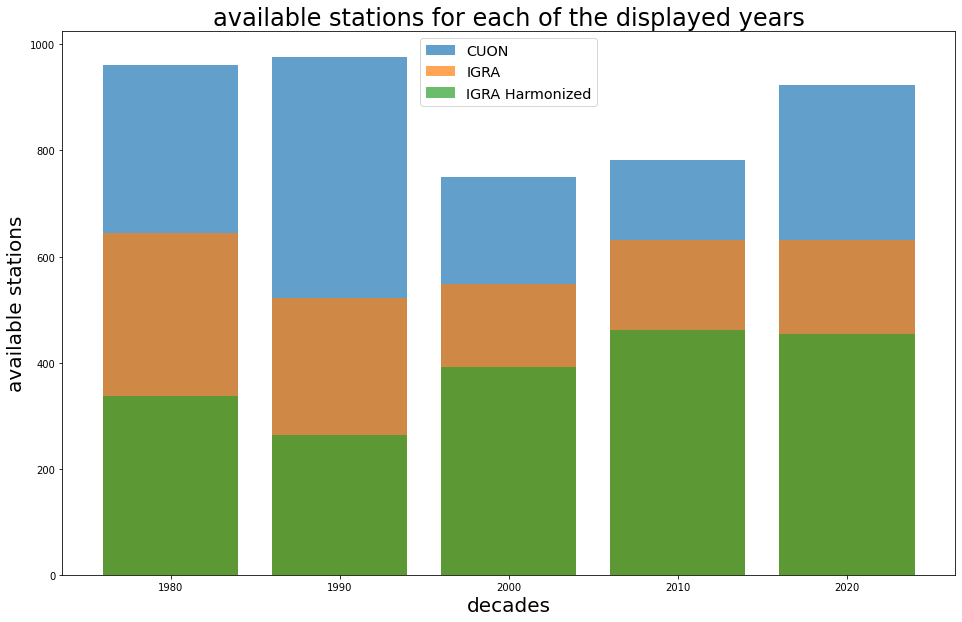

In [8]:
decades = ['1980', '1990', '2000', '2010','2020']

fig, (ax1) = plt.subplots(1, 1)

ax1.bar(decades, statscuon, label='CUON', alpha=0.7)
ax1.bar(decades, statsigra, label='IGRA', alpha=0.7)
ax1.bar(decades, statsigrah, label='IGRA Harmonized', alpha=0.7)

ax1.set(xlabel ='decades', ylabel='available stations', title='available stations for each of the displayed years')
ax1.legend( loc='best')
plt.show()
plt.close(fig)

## Requesting the global data and checking for the number of available messurements per station


In [9]:
# decades = ['1980-01-01/1989-12-31','1990-01-01/1999-12-31','2000-01-01/2009-12-31','2010-01-01/2019-12-31']   
# decnames = ['1980s','1990s','2000s','2010s'] 

### IGRA

In [10]:
# for i in range(len(decades)):
#     da_ih = request({
#             'source': 'IGRA_H',
#             'variable': ['air_temperature'],
#             'period': decades[i],
#         }, igra)
#     with open('IGRAH_'+decnames[i]+'.p', 'wb') as handle:
#         pickle.dump(da_ih, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('IGRAH_01_2000s.p', 'rb') as handle:
#     b = pickle.load(handle)
# with open('IGRAH_02_2000s.p', 'rb') as handle:
#     a = pickle.load(handle)
# b=b.append(a)

# # with open('IGRAH_1980s.p', 'rb') as handle:
# #     b = pickle.load(handle)
    
# b=b.append(a)

# b = b[b.air_pressure == 50000]
# b

# b = b.dropna(axis=0, how='any')
# b

# out = pandas.DataFrame(columns=['lat', 'lon', 'obs'])
# for i in b.drop_duplicates('station_name')['station_name']:
#     check = b[b.station_name == i]
#     out = out.append({'lat': check.iloc[0].latitude, 'lon': check.iloc[0].longitude, 'obs': len(check)}, ignore_index=True)
# with open('/raid60/scratch/uli/igrah_500hpa_2000s.p', 'wb') as handle:
#     pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)

### CUON

In [11]:
i = glob.glob('/raid60/scratch/uli/ig*500*.p')
print(i)
c = glob.glob('/raid60/scratch/uli/cuon_n*500*.p')
print(c)

['/raid60/scratch/uli/igrah_500hpa_1980s.p', '/raid60/scratch/uli/igrah_500hpa_1990s.p', '/raid60/scratch/uli/igrah_500hpa_2010s.p', '/raid60/scratch/uli/igrah_500hpa_2000s.p']
['/raid60/scratch/uli/cuon_n_500hpa_1980s.p', '/raid60/scratch/uli/cuon_n_500hpa_1990s.p', '/raid60/scratch/uli/cuon_n_500hpa_2000s.p', '/raid60/scratch/uli/cuon_n_500hpa_2010s.p']


/raid60/scratch/uli/igrah_500hpa_1980s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_1980s'}>

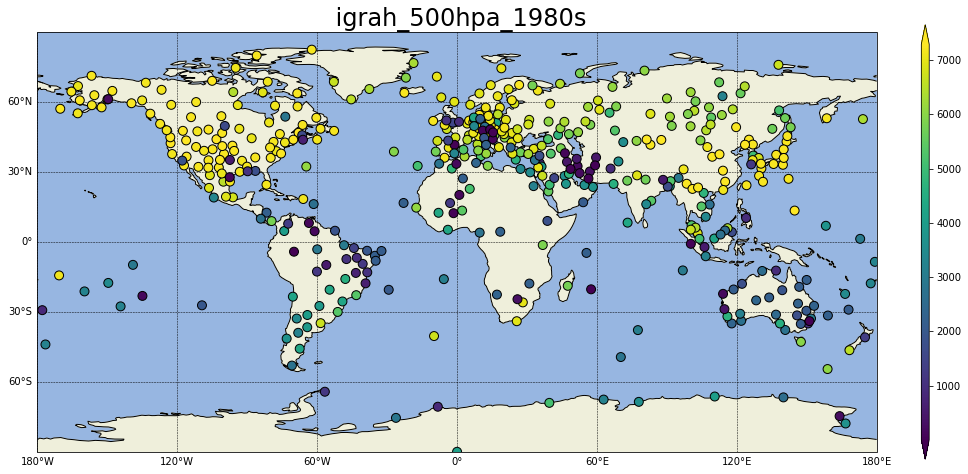

In [12]:
with open(i[0], 'rb') as handle:
    a = pickle.load(handle)
    print(i[0])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[0].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_n_500hpa_1980s.p


<GeoAxesSubplot:title={'center':' cuon_n_500hpa_1980s'}>

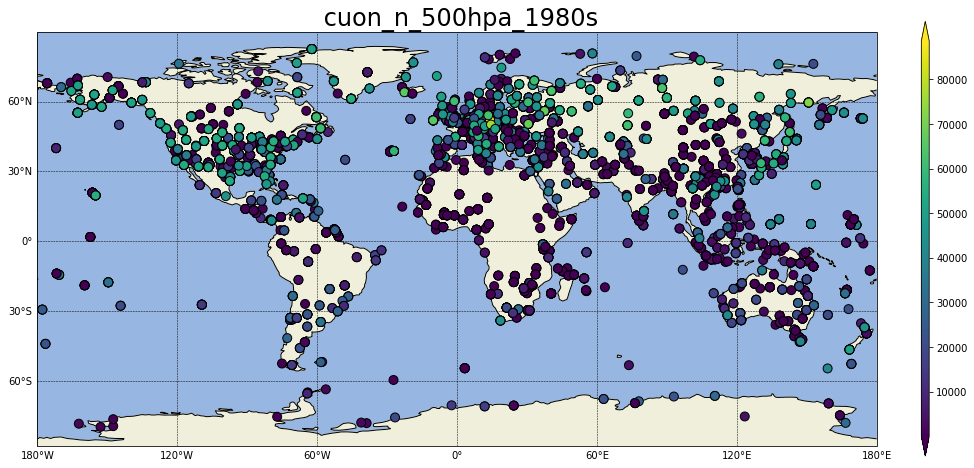

In [13]:
with open(c[0], 'rb') as handle:
    b = pickle.load(handle)
    print(c[0])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[0].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_n_500hpa_1980s -> 0\nigrah_500hpa_1980s -> 1'}>

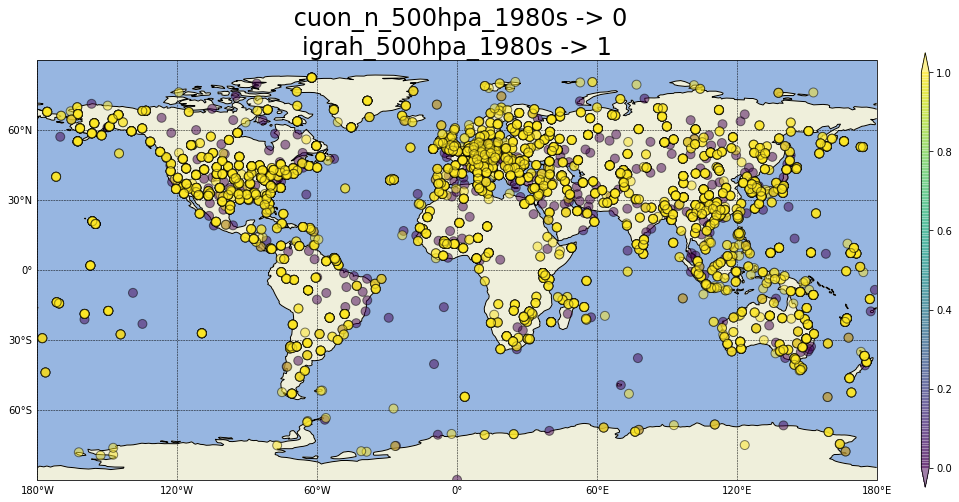

In [14]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[0].split('/')[-1][:-2] + ' -> 0'+ '\n' + i[0].split('/')[-1][:-2] +' -> 1')

/raid60/scratch/uli/igrah_500hpa_1990s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_1990s'}>

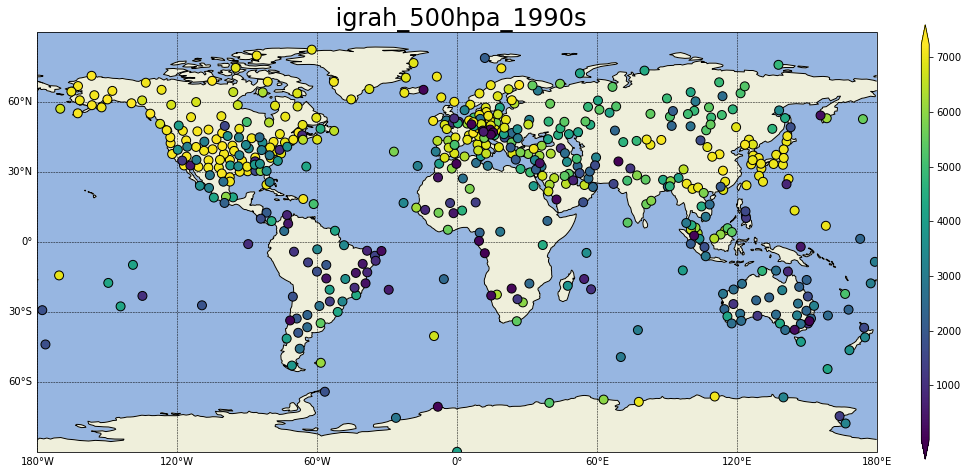

In [15]:
with open(i[1], 'rb') as handle:
    a = pickle.load(handle)
    print(i[1])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[1].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_n_500hpa_1990s.p


<GeoAxesSubplot:title={'center':' cuon_n_500hpa_1990s'}>

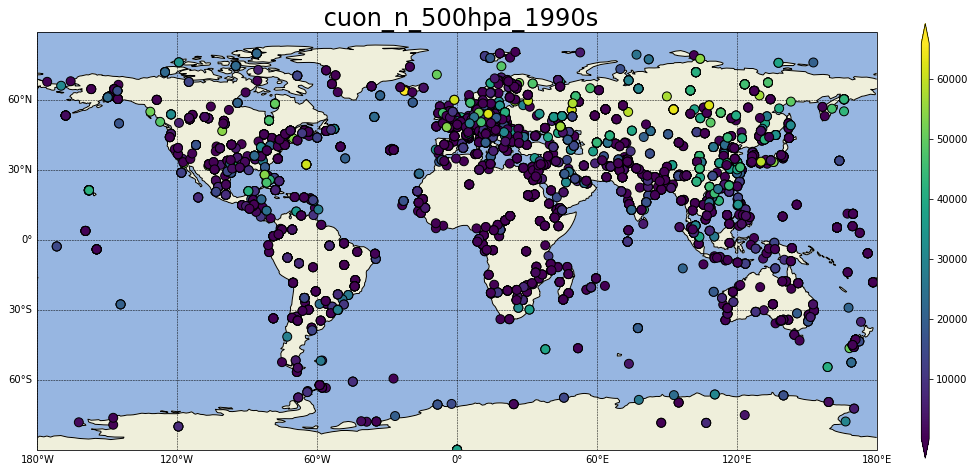

In [16]:
with open(c[1], 'rb') as handle:
    b = pickle.load(handle)
    print(c[1])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[1].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_n_500hpa_1990s -> 0\nigrah_500hpa_1990s -> 1'}>

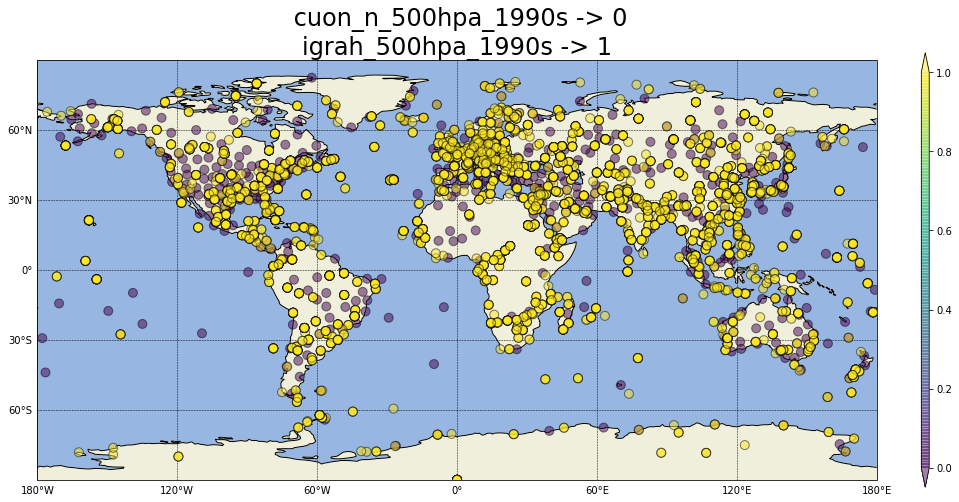

In [17]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[1].split('/')[-1][:-2] + ' -> 0'+ '\n' + i[1].split('/')[-1][:-2] +' -> 1')

/raid60/scratch/uli/igrah_500hpa_2000s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_2000s'}>

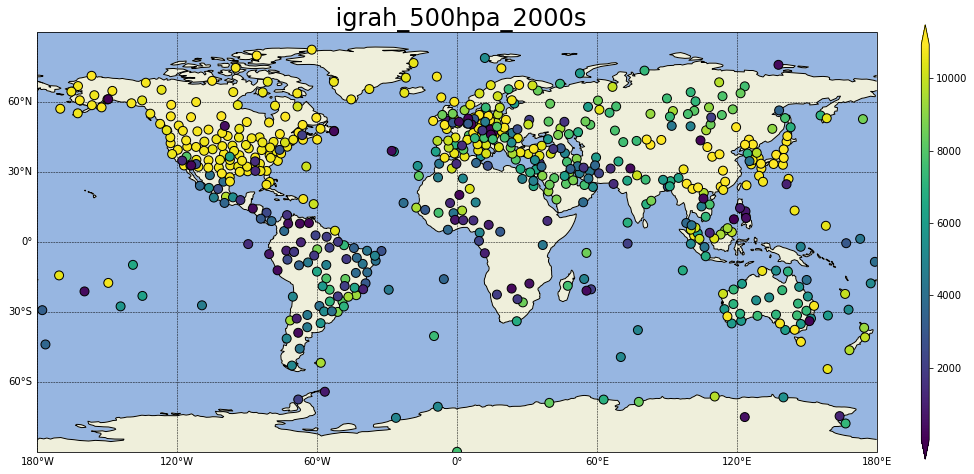

In [18]:
with open(i[3], 'rb') as handle:
    a = pickle.load(handle)
    print(i[3])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[3].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_n_500hpa_2000s.p


<GeoAxesSubplot:title={'center':' cuon_n_500hpa_2000s'}>

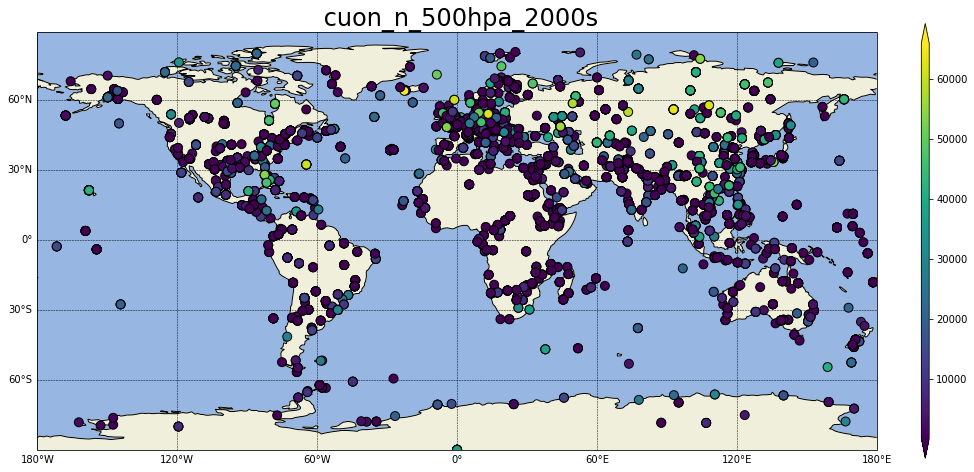

In [19]:
with open(c[2], 'rb') as handle:
    b = pickle.load(handle)
    print(c[2])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[2].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_n_500hpa_2000s -> 0\nigrah_500hpa_2000s -> 1'}>

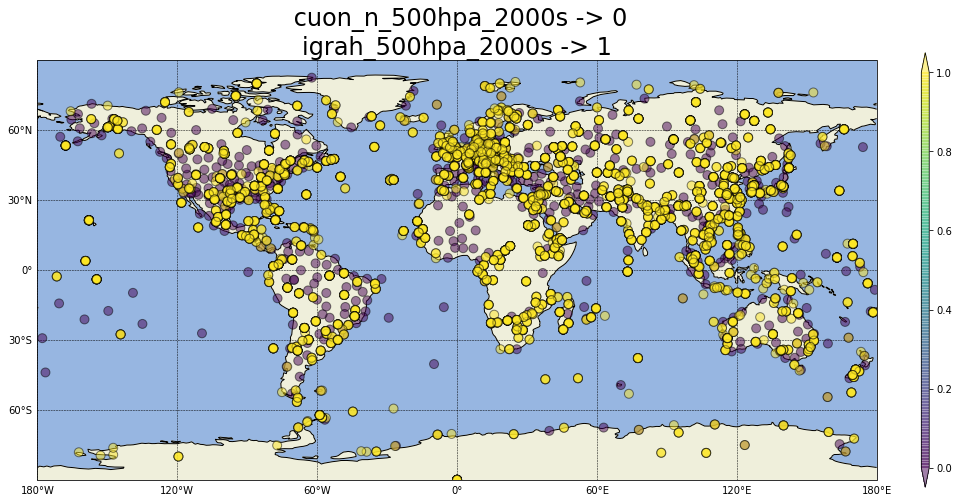

In [20]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[2].split('/')[-1][:-2] + ' -> 0'+ '\n' + i[3].split('/')[-1][:-2] +' -> 1')

/raid60/scratch/uli/igrah_500hpa_2010s.p


<GeoAxesSubplot:title={'center':' igrah_500hpa_2010s'}>

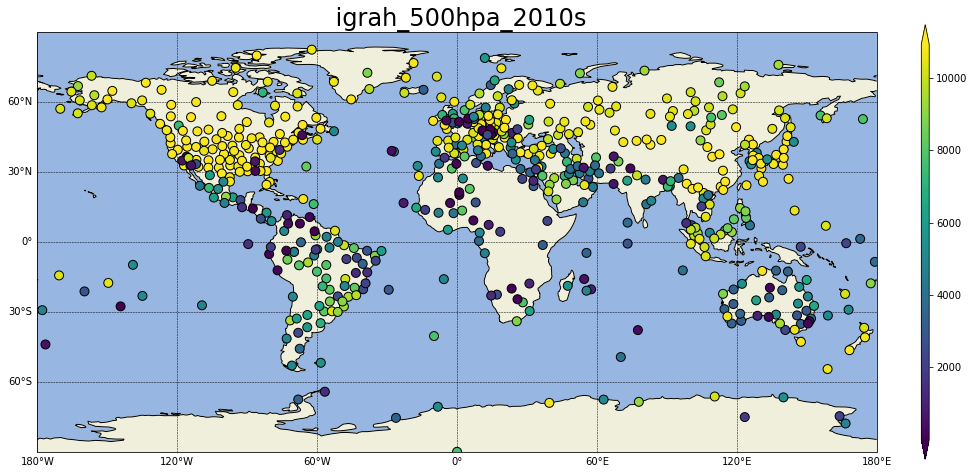

In [21]:
with open(i[2], 'rb') as handle:
    a = pickle.load(handle)
    print(i[2])
points(lon=a.lon, lat=a.lat, values=a.obs, showtitle=i[2].split('/')[-1][:-2])

/raid60/scratch/uli/cuon_n_500hpa_2010s.p


<GeoAxesSubplot:title={'center':' cuon_n_500hpa_2010s'}>

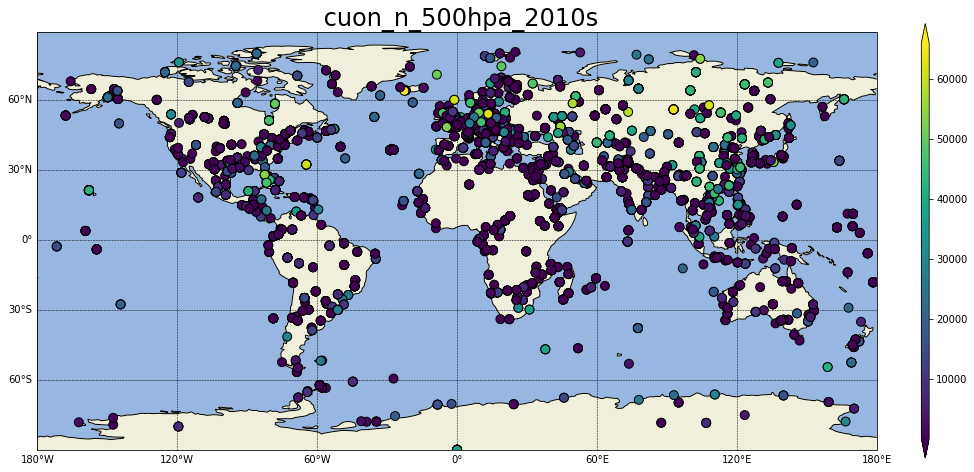

In [22]:
with open(c[3], 'rb') as handle:
    b = pickle.load(handle)
    print(c[3])
points(lon=b.lon, lat=b.lat, values=b.obs, showtitle=c[3].split('/')[-1][:-2])

<GeoAxesSubplot:title={'center':' cuon_n_500hpa_2010s -> 0\nigrah_500hpa_2010s -> 1'}>

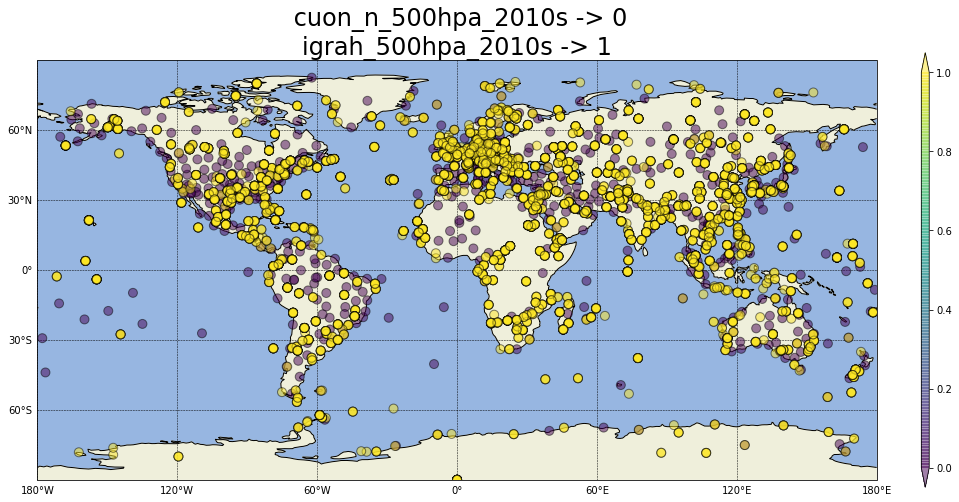

In [23]:
a['obs'].values[:] = 0
compare_i = a
b['obs'].values[:] = 1
compare_c = b
compare = pandas.DataFrame.append(compare_i, compare_c)
points(lon=compare.lon, lat=compare.lat, values=compare.obs, showalpha=0.5, showtitle=c[3].split('/')[-1][:-2] + ' -> 0'+ '\n' + i[2].split('/')[-1][:-2] +' -> 1')